# Backprop to RL

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/NiloufarRazmi/RL_Olfaction/HEAD?labpath=.%2Fbackprop%2Fbackprop.ipynb)

1. inputs need to reflect position in arena and odor (NOT CONJUNCTIONS)
2. outputs need to reflect action values
3. actions are selected via softmax on output neuron activity. 
4. RPE requires knowing value of new state -- so this will require a forward pass using "new state" inputs.

Basically, i'm just coding up what is here:
https://en.wikipedia.org/wiki/Backpropagation
under heading: Finding the derivative of the error

Goal is to make a simple multi layer network, feed it an "exclusive or"
problem, then use backprop to solve it.

Originally I was going to code up a 3 layer network for simplicity -- but
it appears to work better on x/or if i give it more layers. I think its
because the non-linearity (logistic) is not very extreme, and a couple
layers can work together to make it a sharper non-linearity. 

Currently uses a logistic activation function:
$$ f(x) = \frac{1}{1+e^{-x}} $$




Here is what it looks like:
```python
x = np.arange(-5, 5, 0.1)
y = 1.0 / (1 + np.exp(-x))
plt.plot(x, y)
plt.show()
```

In [1]:
# Import packages
import numpy as np
from tqdm import tqdm

# import pandas as pd
# import json

# Replace by `%matplotlib inline` in case you get javascript issues
%matplotlib ipympl
import matplotlib.pyplot as plt
import ipywidgets as widgets

%load_ext lab_black

## Main options:

In [2]:
dropdown = widgets.Dropdown(
    options=[("easy", 1), ("hard", 2), ("super hard", 3)],
    value=2,
    description="Problem",
    disabled=False,
)  # 3 = super hard, 2 = hard, 1 = easy. See below for actual functions.
display(dropdown)

Dropdown(description='Problem', index=1, options=(('easy', 1), ('hard', 2), ('super hard', 3)), value=2)

In [3]:
nLayers = 5  # set number of layers for neural network

## Step 1: generate data

In [4]:
nTrain = 1000000
nTest = 100

In [5]:
nTot = nTrain + nTest
# create two normal input channels
X = np.random.multivariate_normal([0, 0], 10 * np.eye(2), size=nTot)
# X = pd.read_csv("X.csv", header=None).to_numpy()
# Y is positive if X(1) & X(2) are positive, OR if X(1) and X(2) are negative.
X.shape

(1000100, 2)

In [6]:
problem = dropdown.value
if problem == 1:
    # Easy problem: LINEAR
    Y = np.sum(X, 1) > 0
elif problem == 2:
    # Hard problem = EXCLUSIVE OR
    Y = np.sign(X[:, 0] * X[:, 1]) / 2.0 + 0.5
elif problem == 3:
    # Super hard problem = CIRCLE
    Y = np.sqrt(X[:, 0] ** 2 + X[:, 1] ** 2) < 4

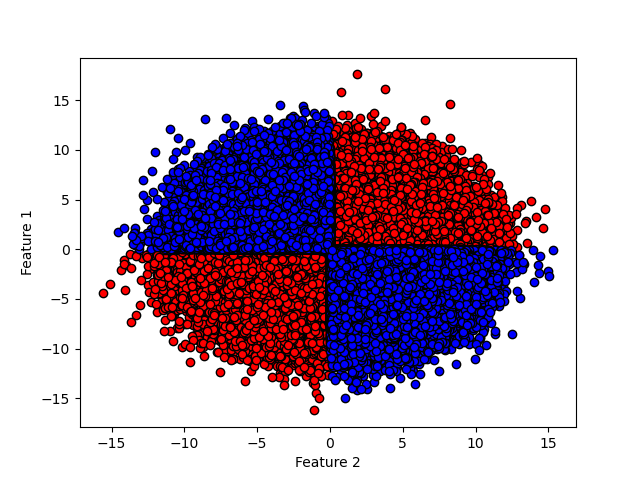

In [7]:
fig1 = plt.figure(1)
fig1.clear(True)
plt.plot([-2, 2], [0, 0], "--k")
plt.plot([0, 0], [-2, 2], "--k")
plt.plot(
    X[Y == 1, 0],
    X[Y == 1, 1],
    "o",
    markerfacecolor="r",
    linewidth=1,
    markeredgecolor="k",
)
plt.plot(
    X[Y == 0, 0],
    X[Y == 0, 1],
    "o",
    markerfacecolor="b",
    linewidth=1,
    markeredgecolor="k",
)
plt.ylabel("Feature 1")
plt.xlabel("Feature 2")
plt.show()

## Step 2: Build network

In [8]:
# determine number of units in each layer
nOutputUnits = 1
nInputUnits = X.shape[1]
nHiddenUnits = 20
initVar = 1
nonLin = np.block([False, np.ones((1, nLayers - 2), dtype=bool), True]).squeeze()

# Create initial weight matrices
nUnits = np.block([nInputUnits, np.repeat(nHiddenUnits, nLayers - 2), nOutputUnits])
wtMatrix = []
for i in range(0, nLayers - 1):
    wtMatrix.append(np.random.normal(0, initVar, (nUnits[i], nUnits[i + 1])))

# wtMatrix.append(np.array([[10, 10, -10, -10], [10, -10, 10, -10]]))

# with open("wtMatrix.json", "rb") as f:
#     wt = json.load(f)
# wtMatrix = []
# for cell in wt:
#     wtMatrix.append(np.array(cell))

## Step 3: Train network

In [9]:
LR = 0.001

allError = np.nan * np.ones(nTot)
catPredict = np.nan * np.ones(nTot)

for i in tqdm(range(nTrain)):

    # Generate model prediction (forward pass of activity through units):
    activity = [np.array([]) for _ in range(nLayers)]
    for j in range(nLayers):
        # Determine layer input:
        if j == 0:
            input = X[i, :]  # THIS WILL BE YOUR POSITION/ODOR!!!!!
        else:
            if activity[j].shape == ():
                input = activity[j - 1] * wtMatrix[j - 1]
            else:
                input = activity[j - 1] @ wtMatrix[j - 1]

        # Apply non-linearity
        if nonLin[j]:
            activity[j] = 1.0 / (1.0 + np.exp(-input))
        else:
            activity[j] = input

        # Take an action! softmax over actions or similar

        # incorporate your model of the task, to dedtermine where agent actually goes.

        # Now you need to do another forward pass, to see how good the new
        # state is so that you can compute the RPE below.

        # your RPE will differ from the one below, should look something like this:
        # RPE =  R - X(S)*W+ DISCOUNT*max(X(S')*W)

    # Backpropagate errors to compute gradients for all layers:
    delta = [np.array([]) for _ in range(nLayers)]
    for j in reversed(range(nLayers)):
        # Determine layer input:
        if j == nLayers - 1:
            # IF there is nonlinearity, should multiply by derivative of
            # activation with respect to input (activity.*(1-activity)) here.
            delta[j] = (Y[i] - activity[j]) * (
                activity[j] * (1.0 - activity[j])
            ).T  # THIS SHOULD BE REPLACED WITH YOUR RPE!

            # doing this in RL framework means that you'll need one RPE for
            # each output neuron -- so RPE computed above should be
            # associated with the action agent took... all other RPEs
            # should be zero.

        else:
            # OK, here is the magic -- neurons in layer j share the
            # gradient (ie. prediction errors) from the next layer
            # according to their responsibility... that is to say, if I
            # project to a unit in next layer with a strong weight,
            # then i inherit the gradient (PE) of that unit.
            if (
                delta[j + 1].shape == ()
            ):  # Not very pretty but I don't know if there's a better way to do that...
                delta[j] = (
                    wtMatrix[j] * delta[j + 1] * (activity[j] * (1.0 - activity[j])).T
                )
            else:
                delta[j] = (
                    wtMatrix[j] @ delta[j + 1] * (activity[j] * (1.0 - activity[j])).T
                )

    # Update weight matrices according to gradients and activities:
    for j in range(len(wtMatrix) - 1):
        wtMatrix[j] = (
            wtMatrix[j] + LR * np.expand_dims(activity[j], axis=1) * delta[j + 1].T
        )

    # store error:
    allError[i] = delta[-1]
    catPredict[i] = activity[-1] > 0.5

100%|███████████████████████████████████████████████████| 1000000/1000000 [01:12<00:00, 13818.48it/s]


In [10]:
activity

[array([-1.1105925 , -0.33896472]),
 array([0.64593117, 0.61673049, 0.04405777, 0.12641023, 0.31759988,
        0.14310378, 0.77955272, 0.08340838, 0.83251239, 0.3975136 ,
        0.20237454, 0.37131479, 0.04832604, 0.6859316 , 0.94677455,
        0.37418812, 0.54322463, 0.12210252, 0.66902499, 0.18433409]),
 array([0.56515463, 0.02012661, 0.36891389, 0.9539639 , 0.69156419,
        0.67017248, 0.17930265, 0.92104278, 0.60148886, 0.15791581,
        0.00267138, 0.06872571, 0.30569546, 0.8008125 , 0.09719455,
        0.32590585, 0.42197327, 0.01485972, 0.98014649, 0.66494093]),
 array([8.06451992e-02, 5.59677593e-01, 2.47251224e-01, 4.19591881e-01,
        9.82176596e-01, 3.37474663e-01, 4.52173932e-04, 8.65555896e-01,
        6.47291455e-01, 1.38374621e-01, 4.51622474e-02, 9.92013340e-01,
        3.16011128e-01, 3.01593533e-01, 9.99217156e-01, 6.94837931e-01,
        3.26454478e-02, 2.68811158e-02, 6.28845429e-01, 5.91179456e-01]),
 array([0.83738813])]

In [11]:
delta

[array([0.04825372, 0.04060889]),
 array([-1.44114329e-03,  3.84158937e-03, -1.28621316e-03,  2.51583446e-04,
        -5.26214423e-03, -4.34468211e-03, -1.47549607e-03,  3.02604873e-04,
         2.37798511e-03, -3.66788423e-03, -2.28749047e-03, -9.40721847e-03,
        -2.46839910e-03,  6.35962975e-03,  1.46954716e-03, -1.01612400e-02,
         5.13962848e-03,  9.33866791e-05,  4.45310363e-03, -3.33954452e-04]),
 array([ 5.40538418e-03, -2.63751988e-04, -1.23756918e-02,  5.10930346e-04,
         1.96751078e-03, -2.66546340e-03, -4.15283109e-03, -8.53119683e-05,
         3.15057439e-03, -5.89470393e-03,  1.33033281e-04, -1.02590999e-03,
         3.73229091e-03,  5.86685691e-05,  5.93956236e-04, -1.09738553e-03,
        -3.27593716e-03, -6.27252130e-04, -7.01683750e-05,  1.30562946e-04]),
 array([ 1.77468625e-03,  3.04413044e-03,  5.32680245e-03,  9.03365207e-04,
         4.07956863e-04, -4.40509955e-04, -4.89861379e-07,  2.16426889e-03,
         2.26099189e-03,  2.17209209e-03,  4.76204

In [12]:
allError

array([-0.04119392, -0.06935093, -0.05823094, ...,         nan,
               nan,         nan])

In [13]:
catPredict

array([ 1.,  1.,  1., ..., nan, nan, nan])

In [14]:
Bins = np.round(np.linspace(0, len(allError), num=100)).astype(int)

meanError = np.zeros_like(Bins) * np.nan
for i in range(len(Bins) - 1):
    meanError[i] = np.nanmean(abs(allError[Bins[i] : Bins[i + 1]]))
meanError

array([0.05720942, 0.09472728, 0.10061162, 0.09777411, 0.0938819 ,
       0.08928425, 0.08559627, 0.0810537 , 0.07714438, 0.07416887,
       0.07019126, 0.06755972, 0.06421406, 0.06214933, 0.05920138,
       0.0577024 , 0.05557133, 0.05285492, 0.05163122, 0.04965648,
       0.04834991, 0.04785725, 0.04583223, 0.04469603, 0.04323354,
       0.04273886, 0.04169996, 0.04139165, 0.04069812, 0.0399203 ,
       0.03848338, 0.03789657, 0.03760586, 0.03664296, 0.03589217,
       0.03541186, 0.03443033, 0.03411379, 0.0338745 , 0.03380177,
       0.03308757, 0.03295943, 0.03216025, 0.03103193, 0.03186999,
       0.03142989, 0.0307945 , 0.03027429, 0.02947686, 0.0297753 ,
       0.02953606, 0.02880779, 0.02845088, 0.02800302, 0.02827222,
       0.02791923, 0.02749046, 0.02788761, 0.02754644, 0.02691929,
       0.02656846, 0.02656498, 0.0262081 , 0.02598165, 0.02585761,
       0.02542805, 0.0254184 , 0.0253447 , 0.02518986, 0.02431372,
       0.02448974, 0.02451203, 0.02453795, 0.02395537, 0.02357

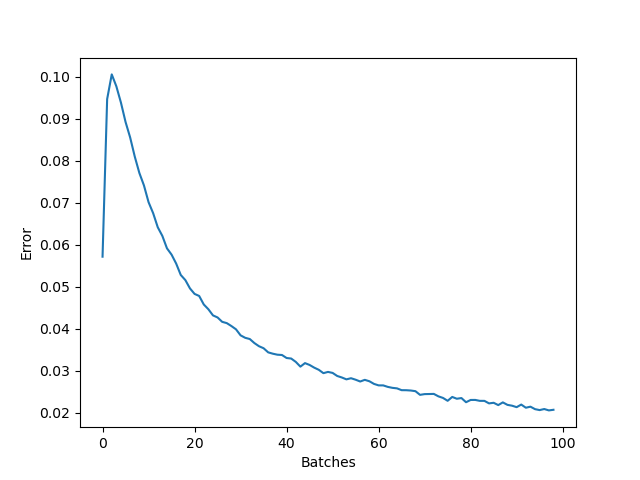

In [15]:
fig2 = plt.figure(2)
fig2.clear(True)
plt.plot(meanError)
plt.ylabel("Error")
plt.xlabel("Batches")
plt.show()

## Step 4: Test Network

In [16]:
for i in range((nTrain + 1), nTot):
    # Generate model prediction (forward pass of activity through units):
    activity = [np.array([]) for _ in range(nLayers)]
    for j in range(nLayers):
        # Determine layer input:
        if j == 0:
            input = X[i, :]  # initial layer is activated according to input
        else:
            input = activity[j - 1] @ wtMatrix[j - 1]

        # Apply non-linearity
        if nonLin[j]:
            activity[j] = 1.0 / (1.0 + np.exp(-input))
        else:
            activity[j] = input

    # store error
    allError[i] = delta[-1]
    catPredict[i] = activity[-1] > 0.5

isTest = np.zeros(nTot, dtype=bool)
isTest[nTrain + 1 :] = True

In [17]:
activity

[array([-4.8640145 , -3.75774671]),
 array([9.99492109e-01, 9.96570972e-01, 1.86675882e-06, 9.87492714e-03,
        7.77776102e-05, 2.17172664e-05, 9.94850025e-01, 3.87161448e-06,
        9.97682629e-01, 5.96378004e-03, 3.01802942e-03, 2.25248849e-03,
        2.30802000e-06, 9.99758089e-01, 9.99996722e-01, 2.64897959e-03,
        9.77724816e-01, 1.93115717e-04, 9.99629539e-01, 4.10656265e-05]),
 array([7.93893659e-01, 7.07794476e-02, 4.45646571e-02, 9.93809548e-01,
        9.11189645e-01, 5.05832779e-01, 2.81856073e-02, 9.63805019e-01,
        8.53161163e-01, 4.50374474e-03, 2.31270875e-04, 8.01750977e-03,
        6.83529190e-01, 9.65872407e-01, 3.68203129e-01, 2.78760909e-01,
        2.60692118e-01, 7.94337564e-02, 9.97696445e-01, 7.33188033e-01]),
 array([9.52598782e-02, 8.57821705e-01, 3.39757203e-01, 5.90681842e-01,
        8.49665361e-01, 5.26170014e-01, 1.11913127e-04, 9.40451053e-01,
        8.50643812e-01, 1.54592693e-01, 3.85980510e-02, 9.86252115e-01,
        4.55799310e-01, 

In [18]:
allError

array([-0.04119392, -0.06935093, -0.05823094, ...,  0.02214274,
        0.02214274,  0.02214274])

How does train model do on new data? Lets take a look...

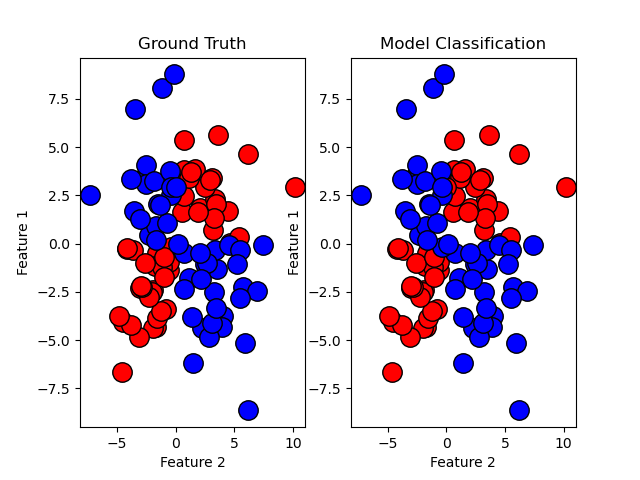

In [19]:
fig3 = plt.figure(3)
fig3.clear(True)
plt.subplot(1, 2, 1)
plt.title("Ground Truth")
# plt.plot([-2, 2], [0, 0], "--k")
# plt.plot([0, 0], [-2, 2], "--k")
plt.plot(
    X[(Y == 1) & isTest, 0],
    X[(Y == 1) & isTest, 1],
    "o",
    markerfacecolor="r",
    linewidth=1,
    markeredgecolor="k",
    markersize=14,
)
plt.plot(
    X[(Y == 0) & isTest, 0],
    X[(Y == 0) & isTest, 1],
    "o",
    markerfacecolor="b",
    linewidth=1,
    markeredgecolor="k",
    markersize=14,
)
plt.ylabel("Feature 1")
plt.xlabel("Feature 2")


plt.subplot(1, 2, 2)
plt.title("Model Classification")
# plt.plot([-2, 2], [0, 0], "--k")
# plt.plot([0, 0], [-2, 2], "--k")
plt.plot(
    X[(catPredict == 1) & isTest, 0],
    X[(catPredict == 1) & isTest, 1],
    "o",
    markerfacecolor="r",
    linewidth=1,
    markeredgecolor="k",
    markersize=14,
)
plt.plot(
    X[(catPredict == 0) & isTest, 0],
    X[(catPredict == 0) & isTest, 1],
    "o",
    markerfacecolor="b",
    linewidth=1,
    markeredgecolor="k",
    markersize=14,
)
plt.ylabel("Feature 1")
plt.xlabel("Feature 2")

plt.show()